### Import thư viện

In [1]:
%matplotlib inline
import numpy as np 
import pandas as pd
from pydicom import dcmread
import os
import scipy.ndimage
import matplotlib.pyplot as plt
from supporters import *
from PIL import Image
import SimpleITK as sitk
import nibabel as nib

### 1. Đọc và tiền xử lý ảnh file dcm

In [3]:
def load_scan(path):
    slices = [dcmread(path + '/' + s) for s in os.listdir(path)]
    slices.sort(key = lambda x: float(x.ImagePositionPatient[2]))
    try:
        slice_thickness = np.abs(slices[0].ImagePositionPatient[2] - slices[1].ImagePositionPatient[2])
    except:
        slice_thickness = np.abs(slices[0].SliceLocation - slices[1].SliceLocation)
    for s in slices:
        s.SliceThickness = slice_thickness
    return slices


def get_pixels_hu(slices):
    image = np.stack([s.pixel_array for s in slices])
    image = image.astype(np.int16)
    image[image == -2000] = 0
    for slice_number in range(len(slices)):
        intercept = slices[slice_number].RescaleIntercept
        slope = slices[slice_number].RescaleSlope
        if slope != 1:
            image[slice_number] = slope * image[slice_number].astype(np.float64)
            image[slice_number] = image[slice_number].astype(np.int16)
        image[slice_number] += np.int16(intercept)  
    return np.array(image, dtype=np.int16)

##### Load folder tất cả bệnh nhân và load bệnh nhân thứ 2

In [12]:
INPUT_FOLDER = '../../data/PatientsDCM/'
patients = os.listdir(INPUT_FOLDER)
patients.sort()

In [58]:
PAT001_scan = load_scan(INPUT_FOLDER + patients[15])
PAT001 = get_pixels_hu(PAT001_scan)
PAT001.shape

(235, 512, 512)

In [ ]:
explore_3D_array(PAT001)

### 2. Thực Hiện Linear Regression để loại bỏ những tấm ảnh gây nhiễu (không chứa tim)

PAT001: 0 $\rightarrow$ 59 and 180 $\rightarrow$ 200

PAT002: 0 $\rightarrow$ 41 and 150 $\rightarrow$ 184

PAT003: 0 $\rightarrow$ 90 and 170 $\rightarrow$ 219

PAT004: 0 $\rightarrow$ 47 and 170 $\rightarrow$ 196

PAT005: 0 $\rightarrow$ 80 and 190 $\rightarrow$ 216

PAT006: 0 $\rightarrow$ 85 and 190 $\rightarrow$ 231

PAT007: 0 $\rightarrow$ 90 and 170 $\rightarrow$ 196

PAT008: 0 $\rightarrow$ 100 and 220 $\rightarrow$ 272

PAT009: 0 $\rightarrow$ 90 and 200 $\rightarrow$ 237

PAT010: 0 $\rightarrow$ 42 and 170 $\rightarrow$ 203

PAT011: 0 $\rightarrow$ 73 and 180 $\rightarrow$ 216

PAT012: 0 $\rightarrow$ 60 and 160 $\rightarrow$ 177

PAT013: 0 $\rightarrow$ 80 and 165 $\rightarrow$ 188

PAT014: 0 $\rightarrow$ 115 and 200 $\rightarrow$ 216

PAT015: 0 $\rightarrow$ 84 and 210 $\rightarrow$ 249

PAT016: 0 $\rightarrow$ 80 and 200 $\rightarrow$ 234

In [89]:
y1 = np.ones(201)
y1[0:60] = y1[180:201] = 0
y1 = pd.DataFrame(y1)

y2 = np.ones(185)
y2[0:41] = y2[150:185] = 0
y2 = pd.DataFrame(y2)

y3 = np.ones(220)
y3[0:90] = y3[170:220] = 0
y3 = pd.DataFrame(y3)

y4 = np.ones(197)
y4[0:47] = y4[170:197] = 0
y4 = pd.DataFrame(y4)

y5 = np.ones(217)
y5[0:80] = y5[190:217] = 0
y5 = pd.DataFrame(y5)

y6 = np.ones(231)
y6[0:85] = y6[190:231] = 0
y6 = pd.DataFrame(y6)

y7 = np.ones(197)
y7[0:90] = y7[170:197] = 0
y7 = pd.DataFrame(y7)

y8 = np.ones(273)
y8[0:100] = y8[220:273] = 0
y8 = pd.DataFrame(y8)

y9 = np.ones(238)
y9[0:90] = y9[200:238] = 0
y9 = pd.DataFrame(y9)

y10= np.ones(204)
y10[0:42] = y10[170:204] = 0
y10 = pd.DataFrame(y10)

y11 = np.ones(217)
y11[0:73] = y11[180:217] = 0
y11 = pd.DataFrame(y11)

y12 = np.ones(178)
y12[0:60] = y12[160:178] = 0
y12 = pd.DataFrame(y12)

y13 = np.ones(189)
y13[0:80] = y13[165:189] = 0
y13 = pd.DataFrame(y13)

y14 = np.ones(217)
y14[0:115] = y14[200:217] = 0
y14 = pd.DataFrame(y14)

y15 = np.ones(250)
y15[0:84] = y15[210:201] = 0
y15 = pd.DataFrame(y15)

y16 = np.ones(235)
y16[0:80] = y16[200:235] = 0
y16 = pd.DataFrame(y16)

In [90]:
y = pd.concat([y1,y2,y3,y4,y5,y6,y7,y8,y9,y10,y11,y12,y13,y14,y15,y16])
y.to_csv('../../data/PatientsDCM/Postprocessing/binary_training_label.csv', index=False)

In [91]:
y = pd.read_csv('../../data/PatientsDCM/Postprocessing/binary_training_label.csv')
y

,0
0,0.0
1,0.0
2,0.0
3,0.0
4,0.0
...,...
3444,0.0
3445,0.0
3446,0.0
3447,0.0


### 3. Cắt tròn với phương trình đường tròn và lưu

In [6]:
ban_kinh = 190
a = b = 512/2

left = top = a - ban_kinh
right = bottom = a + ban_kinh

def euclidian_distance(x, y, a, b):
    dis = ((x - a)**2 + (y - b)**2)**(1/2)
    return dis

crop_imgs = []
def circling():
    for index in range(PAT001.shape[0]):
        img = PAT001[index]
        for x in range(PAT001.shape[1]):
            for y in range(PAT001.shape[2]):
                if euclidian_distance(x, y, a, b) > ban_kinh:
                    img[x,y] = -2000
        img = img[int(top) : int(bottom), int(left) : int(right)]
        crop_imgs.append(img)
        
circling()
crop_imgs = np.array(crop_imgs)
crop_imgs.shape

(201, 380, 380)

In [ ]:
PAT001 = crop_imgs
explore_3D_array(PAT001)

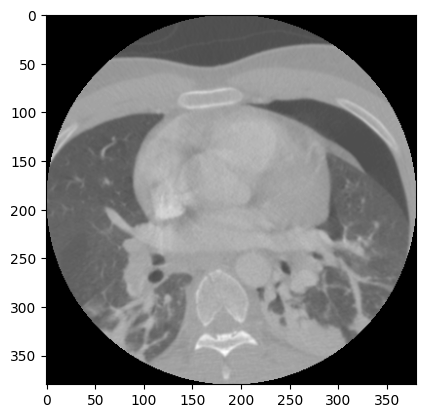

In [8]:
plt.imshow(PAT001[100], cmap="gray")

##### Lưu lại dưới định dạng .nii.gz

In [9]:
out_path = '../../data/PatientsDCM/PAT001/PAT001.nii.gz'
converted_array = np.array(PAT001, dtype=np.float32)
converted_array = np.transpose(converted_array, (2, 1, 0))

affine = np.eye(4)
nifti_file = nib.Nifti1Image(converted_array, affine)
nib.save(nifti_file, out_path)

# reread to check
raw_img_sitk = sitk.ReadImage(out_path, sitk.sitkFloat32)
raw_img_sitk = sitk.GetArrayFromImage(raw_img_sitk)
print(f'Shape of numpy array: {raw_img_sitk.shape}')

Shape of numpy array: (201, 380, 380)


In [ ]:
explore_3D_array_comparison(raw_img_sitk, PAT001)

### 4. Xem và Normalize đơn vị Housefield

Đơn vị Hounsfield (HU) là một đơn vị được sử dụng để thể hiện mật độ phóng xạ của vật liệu trong chụp cắt lớp vi tính (CT). Thang đo HU dựa trên mật độ phóng xạ của không khí và nước, được gán các giá trị lần lượt là -1000 HU và 0 HU. Thang đo HU dao động từ -1000 HU đối với không khí đến +3000 HU đối với xương hoặc kim loại rất dày đặc.  Các vật liệu và mô khác nhau có giá trị HU khác nhau, có thể giúp xác định và phân biệt chúng trên hình ảnh CT.

3071 -2000


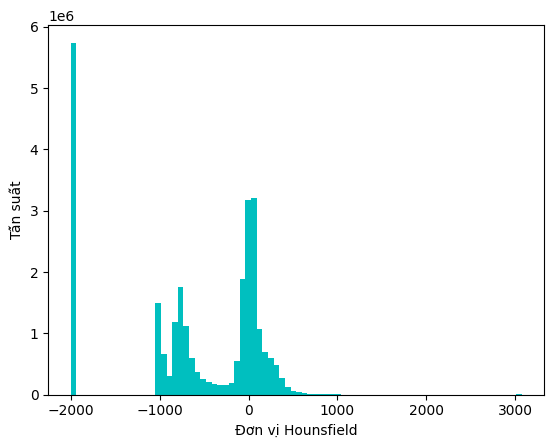

In [80]:
print(np.max(PAT001), np.min(PAT001))

plt.hist(PAT001.flatten(), bins=80, color='c')
plt.xlabel("Đơn vị Hounsfield")
plt.ylabel("Tấn suất")
plt.show()

Tuy nhiên range Hounsfield Unit ở trên chưa chính xác trong vùng hình tròn và có một vài nhiễu +3000

In [85]:
def normalization():
    max_val = min_val = 0
    # Find max min
    for index in range(PAT001.shape[0]):
            img = PAT001[index]
            for x in range(PAT001.shape[1]):
                for y in range(PAT001.shape[2]):
                    if euclidian_distance(x, y, a=PAT001.shape[1]/2, b=PAT001.shape[1]/2) <= ban_kinh: # nằm trong hình tròn
                        if img[x,y] > max_val:
                            max_val = img[x,y] 
                        elif img[x,y] < max_val:
                            min_val = img[x,y] 
    # Intensity normalization                        
    for index in range(PAT001.shape[0]):
        img = PAT001[index]
        for x in range(PAT001.shape[1]):
            for y in range(PAT001.shape[2]):
                if euclidian_distance(x, y, a=PAT001.shape[1]/2, b=PAT001.shape[1]/2) <= ban_kinh: # nằm trong hình tròn
                    img = (img - min_val) / (max_val - min_val)
                    PAT001[index] = img

(3071, -878)

Hoặc Normalize với range tùy chọn

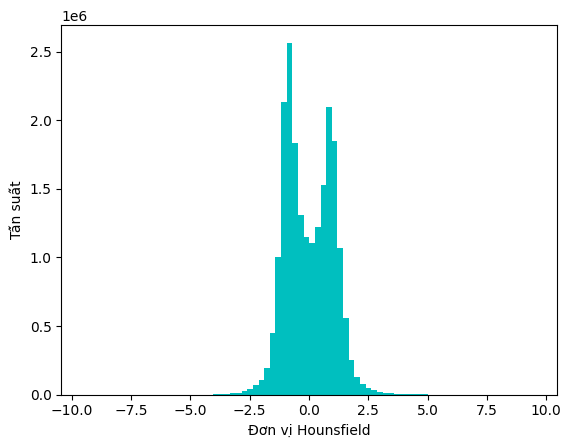

In [88]:
from scipy import stats

in_range = (-1024, 1024)
mask = (PAT001 >= in_range [0]) & (PAT001 <= in_range [1])
masked_array = np.ma.masked_array (PAT001, ~mask)
normalized_array = stats.zscore (masked_array, axis = 0)
normalized_array = normalized_array.filled (0)

plt.hist(normalized_array.flatten(), bins=80, color='c')
plt.xlabel("Đơn vị Hounsfield")
plt.ylabel("Tấn suất")
plt.show()

### Toàn bộ code chạy một lần các các bộ PAT khác nhau

In [5]:
# Supporting functions
INPUT_FOLDER = '../../data/PatientsDCM/'
patients = os.listdir(INPUT_FOLDER)
patients.sort()

def load_scan(path):
    slices = [dcmread(path + '/' + s) for s in os.listdir(path)]
    slices.sort(key = lambda x: float(x.ImagePositionPatient[2]))
    try:
        slice_thickness = np.abs(slices[0].ImagePositionPatient[2] - slices[1].ImagePositionPatient[2])
    except:
        slice_thickness = np.abs(slices[0].SliceLocation - slices[1].SliceLocation)
    for s in slices:
        s.SliceThickness = slice_thickness
    return slices


def get_pixels_hu(slices):
    image = np.stack([s.pixel_array for s in slices])
    image = image.astype(np.int16)
    image[image == -2000] = 0
    for slice_number in range(len(slices)):
        intercept = slices[slice_number].RescaleIntercept
        slope = slices[slice_number].RescaleSlope
        if slope != 1:
            image[slice_number] = slope * image[slice_number].astype(np.float64)
            image[slice_number] = image[slice_number].astype(np.int16)
        image[slice_number] += np.int16(intercept)  
    return np.array(image, dtype=np.int16)

def euclidian_distance(x, y, a, b):
    dis = ((x - a)**2 + (y - b)**2)**(1/2)
    return dis

In [ ]:
def run(index_PAT):
    # Read the volumetric images
    PAT_scan = load_scan(INPUT_FOLDER + patients[index_PAT - 1])
    PAT = get_pixels_hu(PAT_scan)
    
    # Circling and clipping
    ban_kinh = 190
    a = b = 512/2
    left = top = a - ban_kinh
    right = bottom = a + ban_kinh
    crop_imgs = []

    for index in range(PAT.shape[0]):
        img = PAT[index]
        for x in range(PAT.shape[1]):
            for y in range(PAT.shape[2]):
                if euclidian_distance(x, y, a, b) > ban_kinh:
                    img[x,y] = -2000
        img = img[int(top) : int(bottom), int(left) : int(right)]
        crop_imgs.append(img)
    crop_imgs = np.array(crop_imgs)
    
    # Save into .nii.gz file
    index_PAT = '00' + str(index_PAT) if index_PAT < 10 else '0' + str(index_PAT)
    out_path = f'../../data/PatientsDCM/PAT{index_PAT}/PAT{index_PAT}.nii.gz'
    converted_array = np.array(PAT, dtype=np.float32)
    converted_array = np.transpose(converted_array, (2, 1, 0))
    affine = np.eye(4)
    nifti_file = nib.Nifti1Image(converted_array, affine)
    nib.save(nifti_file, out_path)
    
    # Done line
    print(f'{index_PAT} done!')

# Loop through all patients
for index_PAT in range(1, 17, 1):
    run(index_PAT)